In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
np.random.seed(2727)

In [30]:
class Model(tf.Module):
    # Heat equation PINN-solver. 
    def __init__(self, layers_size):

        self.input_dim = layers_size[0]
        self.layers = layers_size
        # List of tf.Tensor objects
        self.W = []

        # Initializer
        init = tf.initializers.GlorotUniform(seed=333)

        for i in range(len(layers_size) - 1):
            input_dim = layers_size[i]
            output_dim = layers_size[i + 1]

            w = tf.Variable(init([output_dim, input_dim], dtype='float64'), trainable=True, name=f'w{i+1}')
            b = tf.zeros([output_dim, 1], dtype='float64')
            b = tf.Variable(b, trainable=True, name=f'b{i+1}')

            self.W.append(w)
            self.W.append(b)

        # Learning rate
        self.learning_rate = 0.01
    
    

    def evaluate(self, x):
        """Evaluates the NN at x.

        Args:
            x : Shape must match the NN input shape.

        Returns:
            tf.Tensor: u_theta(x)
        """
        a = x
        for i in range(len(self.layers) - 2):
            z = tf.add(tf.matmul(self.W[2*i], a), self.W[2*i + 1])
            a = tf.nn.tanh(z)

        a = tf.add(tf.matmul(self.W[-2], a), self.W[-1])
        return a
    
    def function_to_learn(self, data):
        """Function to lear.

        Args:
            data: single data point.

        Returns:
            float.
        """
        return np.sin(data[0][0])
   
    ##################### LOSS METHODS ###########################

    def loss(self, data):
        return tf.subtract(self.evaluate(data), self.function_to_learn(data))

    def boundary_loss(self, boundary_data):
        """Testing for the learning of boundary confitions.

        Args:
            boundary_data: shape=(1,1)
        """
        return self.evaluate(boundary_data)
    
    def total_loss(self, data, boundary_data):
        """Computes the square of the sum of the losses.

        Args:
            data: shape=(1,1)
            boundary_data: shape=(1,1)

        Returns:
            shape=(,)
        """
        return tf.square(self.loss(data) + self.boundary_loss(boundary_data))

    ##################### TRAINING METHODS ###########################


    def apply_gradients(self, gradients_list: list):
        """Updates the parameters according to SGD iteration.

        Args:
            gradients_list (list): list of tf.Tensor
        """
        for g, p in zip(gradients_list, self.W):
            p.assign_sub(self.learning_rate * g)
    
    
    def train(self, num_iter, num_data):
        data_set = [[[x]] for x in np.random.uniform(0,2*np.pi,num_data)]
        boundary_data = [[[x]] for x in np.random.choice([0, 2*np.pi],num_data)]
        l = []
        for _ in tqdm(range(num_iter)):
            j = np.random.randint(num_data)
            with tf.GradientTape() as tape:
                tape.watch(self.W)
                target = self.total_loss(data_set[j], boundary_data[j])
            grads = tape.gradient(target, self.W)
            self.apply_gradients(grads)
            l.append(target)
        return l

            

100%|██████████| 10000/10000 [00:38<00:00, 260.86it/s]


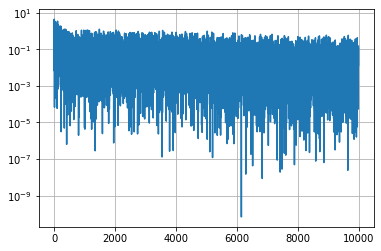

In [31]:
d = 20
model = Model([1,d,d,1])
loss = model.train(10000, 100)
#
values = list(map(lambda v: v[0].numpy(), loss))
plt.plot(values)
plt.grid()
plt.yscale("log")

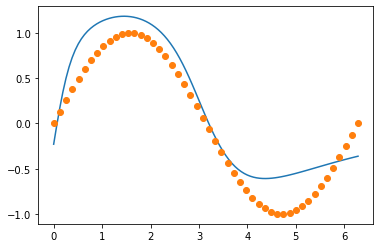

In [36]:
x = np.linspace(0,2*np.pi,100)
y = [model.evaluate([[v]])[0][0].numpy() for v in x]
plt.plot(x,y)
x = np.linspace(0,2*np.pi,50)
z = [np.sin(v) for v in x]
plt.plot(x,z,'o')
